In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load the movie rating data into a dataframe
rating_header = ["user_id", "item_id", "rating", "timestamp"]
rating = pd.read_csv("./ml-100k/u.data", sep = '\t', header = None, names=rating_header)

In [3]:
rating.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
user_id      100000 non-null int64
item_id      100000 non-null int64
rating       100000 non-null int64
timestamp    100000 non-null int64
dtypes: int64(4)
memory usage: 3.1 MB


In [5]:
# load the user data into a dataframe
user_header = ["user_id", "age", "gender", "occupation", "zip_code"]
users = pd.read_csv("./ml-100k/u.user", sep = '|', header = None, names=user_header)

In [6]:
users.head()

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [7]:
users.loc[users['zip_code'] == 'T8H1N']

,user_id,age,gender,occupation,zip_code
73,74,39,M,scientist,T8H1N
633,634,39,M,engineer,T8H1N


In [8]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 5 columns):
user_id       943 non-null int64
age           943 non-null int64
gender        943 non-null object
occupation    943 non-null object
zip_code      943 non-null object
dtypes: int64(2), object(3)
memory usage: 36.9+ KB


In [9]:
# load movie data into a dataframe
movie_header = ["item_id", "title", "release_date", "video_release_date", "IMDb_URL",
         "unknown", "Action", "Adventure", "Animation","Children's", "Comedy", "Crime",
         "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", 
         "Romance", "Sci-Fi", "Thriller", "War", "Western"]
movies = pd.read_csv("./ml-100k/u.item", sep = '|', header = None, encoding = 'latin1', names = movie_header)

In [10]:
# remove the video release date (no values)
movies = movies.drop(columns=['video_release_date'])
movies.head()

,item_id,title,release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [11]:

movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 23 columns):
item_id         1682 non-null int64
title           1682 non-null object
release_date    1681 non-null object
IMDb_URL        1679 non-null object
unknown         1682 non-null int64
Action          1682 non-null int64
Adventure       1682 non-null int64
Animation       1682 non-null int64
Children's      1682 non-null int64
Comedy          1682 non-null int64
Crime           1682 non-null int64
Documentary     1682 non-null int64
Drama           1682 non-null int64
Fantasy         1682 non-null int64
Film-Noir       1682 non-null int64
Horror          1682 non-null int64
Musical         1682 non-null int64
Mystery         1682 non-null int64
Romance         1682 non-null int64
Sci-Fi          1682 non-null int64
Thriller        1682 non-null int64
War             1682 non-null int64
Western         1682 non-null int64
dtypes: int64(20), object(3)
memory usage: 302.3+ KB


# Data Transformation and Combination
Some ML approaches expect the data set with numerical values only, the following codes show how to convert catergorical data into numbers

In [12]:
# transfrom the users dataframe with numerical values (excluding zip_code)
users_num = users.copy()
users_num["gender"].replace(['F', 'M'],[0, 1], inplace=True) # replace F and M with 0 and 1, respectively

In [13]:
occupation = pd.read_csv("./ml-100k/u.occupation", header = None)
occupation_list = occupation.values
users_num["occupation"].replace(occupation_list,list(range(0, len(occupation_list))), inplace=True)
users_num.head()

,user_id,age,gender,occupation,zip_code
0,1,24,1,19,85711
1,2,53,0,13,94043
2,3,23,1,20,32067
3,4,24,1,19,43537
4,5,33,0,13,15213


In [14]:
# data aggregation
average_rating = rating[["item_id", "rating"]].groupby("item_id", as_index=False).mean()  # average rating per movie
average_rating.sort_values("rating",ascending=False).head()

,item_id,rating
813,814,5.0
1598,1599,5.0
1200,1201,5.0
1121,1122,5.0
1652,1653,5.0


In [15]:
# merge two dataframes (average_rating and movies)
pd.merge(average_rating, movies[["item_id", "title"]])

,item_id,rating,title
0,1,3.878319,Toy Story (1995)
1,2,3.206107,GoldenEye (1995)
2,3,3.033333,Four Rooms (1995)
3,4,3.550239,Get Shorty (1995)
4,5,3.302326,Copycat (1995)
5,6,3.576923,Shanghai Triad (Yao a yao yao dao waipo qiao) ...
6,7,3.798469,Twelve Monkeys (1995)
7,8,3.995434,Babe (1995)
8,9,3.896321,Dead Man Walking (1995)
9,10,3.831461,Richard III (1995)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fad70328290>]],
      dtype=object)

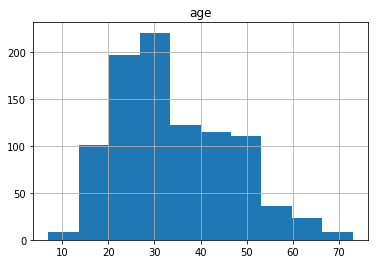

In [16]:
# age intervals distrubution
users.hist(column="age")
#users["age_category"] = pd.cut(users["age"], bins = [0, 10, 20, 30, 40, 50, 60, 70, 80], labels=[5, 15, 25, 35, 45, 55, 65, 75])
#users["age_category"].hist()

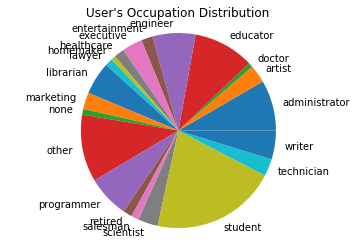

In [17]:
# occupation distrubution
occupation_count = users[["user_id", "occupation"]].groupby("occupation", as_index=False).size()  # count the numbers
plt.pie(occupation_count, labels=occupation_count.index.tolist())
plt.title("User's Occupation Distribution")
plt.axis("equal")
plt.show()

<BarContainer object of 2 artists>

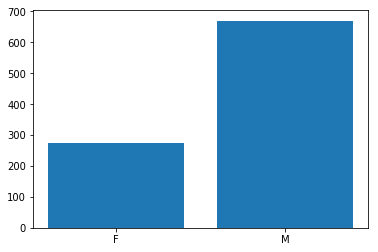

In [18]:
gender_count = users[["user_id", "gender"]].groupby("gender", as_index=False).size()
# print(gender_count.)
plt.bar(gender_count.index.tolist(),gender_count)

# Clustering the movies by genre

In [42]:
n_users = rating.user_id.unique().shape[0]

n_items = rating.item_id.unique().shape[0]
n_items = rating['item_id'].max()
A = np.zeros((n_users,n_items))

for line in rating.itertuples():
    A[line[1]-1,line[2]-1] = line[3]
print("Original rating matrix : ",A)

('Original rating matrix : ', array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]]))


In [20]:
for i in range(len(A)):
    for j in range(len(A[0])):
        
        if A[i][j]>=3:
            
            A[i][j]=1
        else:
            A[i][j]=0

csr_sample = csr_matrix(A)
print(csr_sample)

  (0, 0)	1.0
  (0, 1)	1.0
  (0, 2)	1.0
  (0, 3)	1.0
  (0, 4)	1.0
  (0, 5)	1.0
  (0, 6)	1.0
  (0, 8)	1.0
  (0, 9)	1.0
  (0, 11)	1.0
  (0, 12)	1.0
  (0, 13)	1.0
  (0, 14)	1.0
  (0, 15)	1.0
  (0, 16)	1.0
  (0, 17)	1.0
  (0, 18)	1.0
  (0, 19)	1.0
  (0, 21)	1.0
  (0, 22)	1.0
  (0, 23)	1.0
  (0, 24)	1.0
  (0, 25)	1.0
  (0, 27)	1.0
  (0, 29)	1.0
  :	:
  (942, 624)	1.0
  (942, 654)	1.0
  (942, 671)	1.0
  (942, 684)	1.0
  (942, 716)	1.0
  (942, 720)	1.0
  (942, 721)	1.0
  (942, 731)	1.0
  (942, 738)	1.0
  (942, 762)	1.0
  (942, 764)	1.0
  (942, 793)	1.0
  (942, 795)	1.0
  (942, 807)	1.0
  (942, 815)	1.0
  (942, 823)	1.0
  (942, 824)	1.0
  (942, 839)	1.0
  (942, 927)	1.0
  (942, 942)	1.0
  (942, 1043)	1.0
  (942, 1073)	1.0
  (942, 1187)	1.0
  (942, 1227)	1.0
  (942, 1329)	1.0


In [21]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=3, n_jobs=-1)
knn.fit(csr_sample)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=-1, n_neighbors=3, p=2, radius=1.0)

# predict the movie for user 

In [54]:
dataset_sort_des = rating.sort_values(['user_id', 'rating'], ascending=[True, False])
filter1 = dataset_sort_des[dataset_sort_des['user_id'] == 1].item_id
filter1 = filter1.tolist()
filter1 = filter1[:20]
print("Items liked by user: ",filter1)
print(dataset_sort_des[dataset_sort_des['user_id'] == 1])

('Items liked by user: ', [202, 171, 253, 113, 64, 228, 114, 221, 60, 177, 174, 82, 235, 6, 96, 258, 81, 175, 108, 12])
       user_id  item_id  rating  timestamp
639          1      202       5  875072442
687          1      171       5  889751711
1382         1      253       5  874965970
1440         1      113       5  878542738
2328         1       64       5  875072404
3059         1      228       5  878543541
3234         1      114       5  875072173
3431         1      221       5  887431921
3888         1       60       5  875072370
3909         1      177       5  876892701
4177         1      174       5  875073198
4280         1       82       5  878542589
4974         1      235       5  875071589
5533         1        6       5  887431973
6028         1       96       5  875072716
6541         1      258       5  878873389
6567         1       81       5  875072865
7561         1      175       5  875072547
8834         1      108       5  875240920
8976         1      

In [55]:
distances1=[]
indices1=[]
for i in filter1:
    distances , indices = knn.kneighbors(csr_sample[i],n_neighbors=3)
    indices = indices.flatten()
    print(indices)
    indices= indices[1:]
    indices1.extend(indices)
print("Items to be recommended: ",indices1[:5])

[202  25 581]
[171 311 566]
[253 289 806]
[113 747 866]
[ 64 513 270]
[228 239 712]
[114 420 888]
[221 681 550]
[ 60 334 783]
[177 415 221]
[174 617 487]
[ 82 576 900]
[235 270 715]
[  6 312 845]
[ 96 737 747]
[258 116 247]
[ 81 297 397]
[175 769 581]
[108 221 393]
[ 12 449 307]
('Items to be recommended: ', [25, 581, 311, 566, 289])


In [56]:
recommand_movies_df = pd.DataFrame(indices1[:5],columns = ['item_id'])
print(movies.merge(recommand_movies_df)['title'])

0               Birdcage, The (1996)
1                       Evita (1996)
2      Wings of the Dove, The (1997)
3    Clear and Present Danger (1994)
4                  Kalifornia (1993)
Name: title, dtype: object
